## Combining All ML Models to Compare in ROC Graph

In [1]:
# Load dependencies for all models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

from keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense

import matplotlib
%matplotlib inline  
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
import pickle

from sklearn.metrics import confusion_matrix
import itertools

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

Using TensorFlow backend.


In [2]:
df = pd.read_csv(".\\credit_cards_dataset.csv")
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
print("Original shape of the data: "+ str(df.shape))
features_names = df.columns

Original shape of the data: (30000, 25)


In [4]:
X = df.drop('default.payment.next.month', axis =1).values
y = df['default.payment.next.month'].values
print(X.shape)
print(y.shape)

(30000, 24)
(30000,)


Split my data into training and testing

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Instantiate the random forest model with 200 trees

In [6]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Check feature importance

In [7]:
sorted(zip(rf.feature_importances_, features_names), reverse=True) 

[(0.09035203992307128, 'PAY_0'),
 (0.07134043187762239, 'ID'),
 (0.05584235582292244, 'AGE'),
 (0.05433350017324262, 'BILL_AMT1'),
 (0.05227278575997974, 'LIMIT_BAL'),
 (0.05007525653358332, 'BILL_AMT2'),
 (0.04911574736007864, 'PAY_AMT1'),
 (0.0475839757880149, 'BILL_AMT3'),
 (0.0469839114313028, 'PAY_2'),
 (0.046207788367210505, 'BILL_AMT6'),
 (0.04597728178096867, 'BILL_AMT4'),
 (0.04554221439254836, 'BILL_AMT5'),
 (0.043933701214919865, 'PAY_AMT2'),
 (0.04241365827366272, 'PAY_AMT6'),
 (0.04233826820638078, 'PAY_AMT3'),
 (0.03989995399314921, 'PAY_AMT5'),
 (0.03951919186922271, 'PAY_AMT4'),
 (0.03345246750237501, 'PAY_3'),
 (0.022753287016002825, 'PAY_4'),
 (0.021005591787547642, 'PAY_5'),
 (0.01847488699697647, 'EDUCATION'),
 (0.0169882151676565, 'PAY_6'),
 (0.01280089341808215, 'MARRIAGE'),
 (0.010792595343478418, 'SEX')]

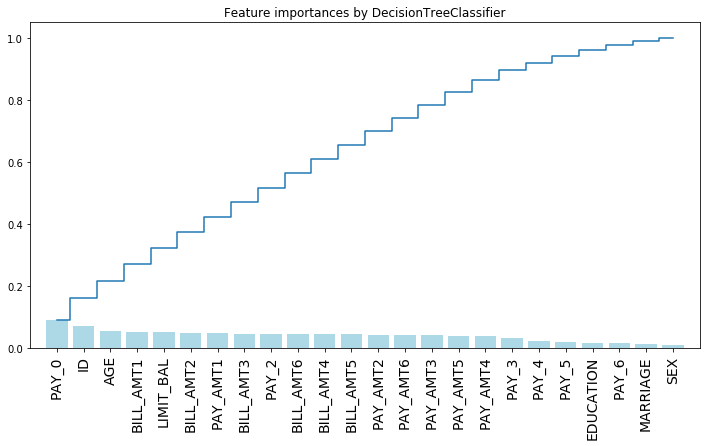

In [8]:
## plot the importances ##
import matplotlib.pyplot as plt
importances = rf.feature_importances_


indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), features_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

Making my prediction and seeing how well my model predicted by checking recall, precision, F1 score and making a confusion matrix.
Recall -tells us generally or overall how well our model predicted based on the total of how much it correctly predicted /correctly predicted + how many where actually right but predicted wrong.

                    formula = TP/TP+FN
Precision -tells us or gives us true measure how well our model predicted it shows correctly predicted /correctly predicted + how many the model predicted to be positive but where false.

                   formula = TP/TP+FP
F1 score - gives us a mean of precision and recall, a sumarization of how well it did in respect to recall and precision.

In [9]:
#Make my predictions
rf_y_prediction = rf.predict(X_test)

In [10]:
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))

In [11]:
print(classification_report(y_test, rf_y_prediction,
                            target_names=["non_default", "default"]))

              precision    recall  f1-score   support

 non_default       0.84      0.94      0.89      7040
     default       0.64      0.37      0.47      1960

    accuracy                           0.82      9000
   macro avg       0.74      0.65      0.68      9000
weighted avg       0.80      0.82      0.80      9000



In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[6632  408]
 [1239  721]]
Normalized confusion matrix
[[0.94 0.06]
 [0.63 0.37]]


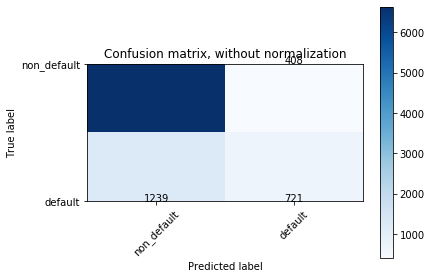

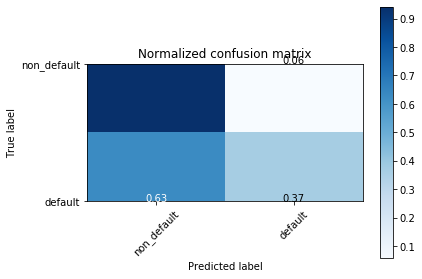

In [13]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, rf_y_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['non_default', 'default'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['non_default', 'default'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Explanation of this confusion matrix
In our confusion matrix, the non-default classification has a total of 2,158 points and defualt clssification has a total of 7,742 points.

It correctly identified 7239 points as default and 503 points as non-default.

Non_default classification incorectly predicted 1480 points as default and correctly classified 678 points as Non defualt.

## Launch Neural Network Model

In [14]:
X_scaler = StandardScaler().fit(X_train)

In [15]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [16]:
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [17]:
nn_model = Sequential()

W1212 15:53:18.311024 16976 module_wrapper.py:139] From C:\Users\heine\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [18]:
nn_model.add(Dense(units = 30, activation ='relu', input_dim=24))
nn_model.add(Dense(units = 20, activation ='relu')) #second hidden layer

W1212 15:53:18.322990 16976 module_wrapper.py:139] From C:\Users\heine\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1212 15:53:18.325980 16976 module_wrapper.py:139] From C:\Users\heine\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [19]:

nn_model.add(Dense(units = 2, activation = 'softmax'))

In [20]:
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                750       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 42        
Total params: 1,412
Trainable params: 1,412
Non-trainable params: 0
_________________________________________________________________


In [21]:
#compile the model
nn_model.compile(optimizer = 'adam' ,
             loss = 'categorical_crossentropy',
             metrics =['accuracy'])

W1212 15:53:18.393863 16976 module_wrapper.py:139] From C:\Users\heine\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1212 15:53:18.419949 16976 module_wrapper.py:139] From C:\Users\heine\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [22]:
#train the model

nn_model.fit(X_train_scaled, y_train_categorical, epochs=100,shuffle = True,verbose =2)

W1212 15:53:18.536417 16976 deprecation.py:323] From C:\Users\heine\Anaconda3\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1212 15:53:18.595294 16976 module_wrapper.py:139] From C:\Users\heine\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1212 15:53:18.689009 16976 module_wrapper.py:139] From C:\Users\heine\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W1212 15:53:18.778769 16976 module_wrapper.py:139] From C:\Users\heine\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1212 15

Epoch 1/100
 - 1s - loss: 0.4826 - acc: 0.8028
Epoch 2/100
 - 1s - loss: 0.4473 - acc: 0.8160
Epoch 3/100
 - 1s - loss: 0.4384 - acc: 0.8187
Epoch 4/100
 - 1s - loss: 0.4319 - acc: 0.8200
Epoch 5/100
 - 1s - loss: 0.4287 - acc: 0.8216
Epoch 6/100
 - 1s - loss: 0.4264 - acc: 0.8217
Epoch 7/100
 - 1s - loss: 0.4242 - acc: 0.8224
Epoch 8/100
 - 1s - loss: 0.4221 - acc: 0.8220
Epoch 9/100
 - 1s - loss: 0.4213 - acc: 0.8224
Epoch 10/100
 - 1s - loss: 0.4194 - acc: 0.8223
Epoch 11/100
 - 1s - loss: 0.4185 - acc: 0.8232
Epoch 12/100
 - 1s - loss: 0.4178 - acc: 0.8251
Epoch 13/100
 - 1s - loss: 0.4167 - acc: 0.8248
Epoch 14/100
 - 1s - loss: 0.4158 - acc: 0.8246
Epoch 15/100
 - 1s - loss: 0.4149 - acc: 0.8245
Epoch 16/100
 - 1s - loss: 0.4141 - acc: 0.8237
Epoch 17/100
 - 1s - loss: 0.4134 - acc: 0.8254
Epoch 18/100
 - 1s - loss: 0.4131 - acc: 0.8247
Epoch 19/100
 - 1s - loss: 0.4120 - acc: 0.8259
Epoch 20/100
 - 1s - loss: 0.4110 - acc: 0.8259
Epoch 21/100
 - 1s - loss: 0.4108 - acc: 0.8251
E

In [23]:
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test_categorical,verbose =2)
print( model_loss )
print (model_accuracy)

0.46293662150700887
0.8091111111111111


In [24]:
nn_y_prediction = nn_model.predict_classes(X_test)

In [25]:
nn_roc_auc = roc_auc_score(y_test, nn_model.predict_classes(X_test))

In [26]:
print(classification_report(y_test, nn_y_prediction,
                            target_names=['non_default', 'default']))

              precision    recall  f1-score   support

 non_default       0.79      0.95      0.86      7040
     default       0.28      0.07      0.11      1960

    accuracy                           0.76      9000
   macro avg       0.53      0.51      0.49      9000
weighted avg       0.68      0.76      0.70      9000



Confusion matrix, without normalization
[[6697  343]
 [1825  135]]
Normalized confusion matrix
[[0.95 0.05]
 [0.93 0.07]]


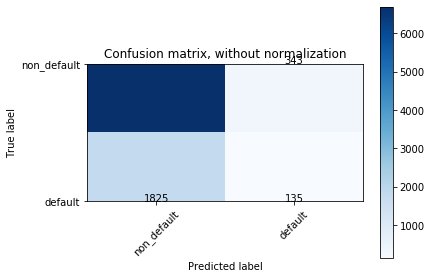

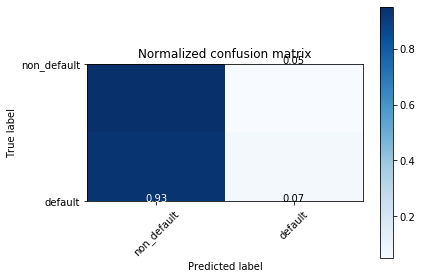

In [27]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, nn_y_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['non_default', 'default'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['non_default', 'default'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Logistic Regression Model 

In [28]:
#creating logistic regression model
classifier = LogisticRegression()
classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
#fitting the model
classifier.fit(X_train, y_train) 

C:\Users\heine\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
log_y_prediction = classifier.predict(X_test)

In [31]:
log_roc_auc = roc_auc_score(y_test, classifier.predict(X_test))

In [32]:
print(classification_report(y_test, log_y_prediction,
                            target_names=['non_default', 'default' ]))

              precision    recall  f1-score   support

 non_default       0.78      1.00      0.88      7040
     default       0.00      0.00      0.00      1960

    accuracy                           0.78      9000
   macro avg       0.39      0.50      0.44      9000
weighted avg       0.61      0.78      0.69      9000



C:\Users\heine\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix, without normalization
[[7040    0]
 [1960    0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


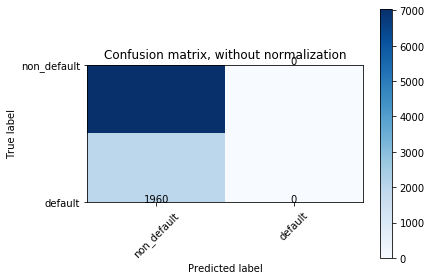

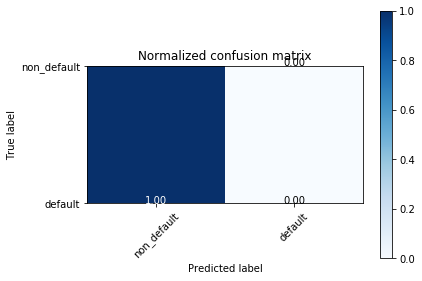

In [33]:
cnf_matrix = confusion_matrix(y_test, log_y_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['non_default', 'default'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['non_default', 'default'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

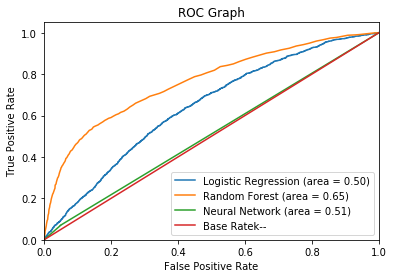

In [34]:
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
nn_fpr, nn_tpr, nn_thresholds = roc_curve(y_test, nn_model.predict_proba(X_test)[:,1])

plt.figure()

# Plot Logistic Regression ROC
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % log_roc_auc)

# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)

# Plot Decision Tree ROC
plt.plot(nn_fpr, nn_tpr, label='Neural Network (area = %0.2f)' % nn_roc_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.savefig('.\\ROC.png')
plt.show()